# compare the optimization performance of SSE and LSE based on iterative CTSM simulations

In [4]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax


def cal_ratio_within_bins(data, bins):
    binsc = np.zeros(len(bins)-1)
    ratio = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        indi = (data>bins[i]) & (data<=bins[i+1])
        ratio[i] = np.sum(indi)/np.sum(~np.isnan(data))
        binsc[i] = (bins[i]+bins[i+1])/2
    return binsc, ratio

# Load data

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# input/out and iteration information
iternum = 4
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/'
outpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

In [5]:
# LSE metrics
outfile = f'{outpath}/LSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_lse_metric = pd.read_csv(outfile, compression='gzip')
else:
    df_lse_metric = []

    for tarbasin in range(len(df_info)):
    # for tarbasin in range(5):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/ctsm_outputs_emutest/iter{i}_many_metric.csv'    
            dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_lse_metric) == 0:
                df_lse_metric = dfi
            else:
                df_lse_metric = pd.concat([df_lse_metric, dfi])
                
    df_lse_metric.to_csv(outfile, index=False, compression='gzip')

In [6]:
# SSE metrics
outfile = f'{outpath}/SSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_sse_metric = pd.read_csv(outfile, compression='gzip')
else:
    df_sse_metric = []
    for tarbasin in range(len(df_info)):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/ctsm_outputs_normKGE/iter{i}_many_metric.csv' 
            if not os.path.isfile(infile):
                print('Warning! File does not exist:', infile)
                # this is not always good
                dfi = dfi.copy()
                dfi[:] = np.nan 
            else:
                dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_sse_metric) == 0:
                df_sse_metric = dfi
            else:
                df_sse_metric = pd.concat([df_sse_metric, dfi])
                
    df_sse_metric.to_csv(outfile, index=False, compression='gzip')

In [7]:
# check if mismatch exists
diff = [df_lse_metric[i].values - df_sse_metric[i].values for i in ['basin','iter','trial'] ]
if np.any(np.array(diff) != 0):
    print('Mismatch between LSE and SSE metrics')
else:
    print('LSE and SSE metrics match each other')

LSE and SSE metrics match each other


In [8]:
# get the performance of default parameters in each basin (1st trial in iter-0)
index = (df_lse_metric['iter']==0) & (df_lse_metric['trial']==0)
df_defa_metric = df_lse_metric[index]
df_defa_metric.index = np.arange(len(df_defa_metric))
print(len(df_defa_metric))

if np.any(df_sse_metric[index].values[:,0] != df_defa_metric.values[:,0]):
    print('Mismatch in default parameter values')
else:
    print('Default parameter metrics match')

627
Default parameter metrics match


In [9]:
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELSandTDX_areabias_fix.simp0.001.level1_hist_78pfts_CMIP6_simyr2000_HAND_4_col_hillslope_geo_params_nlcd_bedrock.nc'
dssurf = xr.load_dataset(file)

# Quick check

In [10]:
num = 0
for b in range(len(df_info)):
    dfb = df_sse_metric[ (df_sse_metric['basin']==b) & (df_sse_metric['iter']==0) ]
    kgeb = dfb['kge'].values
    if np.nanmax(kgeb) == kgeb[0]:
        num = num+1
print('basins whether iteration-0 is worse than the default parameters:', num)

basins whether iteration-0 is worse than the default parameters: 4


# Overall improvements of each iteration
Note this may not be very informative because for example, iter-2 improves iter-1 is probably due to low iter-1 performance

In [11]:
metname = 'kge'
met_stats_lse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_lse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values

        met_stats_lse[j, i, 0] = np.nanmax(dij)
        met_stats_lse[j, i, 1] = np.nanmean(dij)
        met_stats_lse[j, i, 2] = np.nanmedian(dij)


met_stats_sse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_sse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_sse_metric['basin']==j)
        dij = df_sse_metric[indij][metname].values

        met_stats_sse[j, i, 0] = np.nanmax(dij)
        met_stats_sse[j, i, 1] = np.nanmean(dij)
        met_stats_sse[j, i, 2] = np.nanmedian(dij)

/glade/derecho/scratch/guoqiang/tmp/ipykernel_60203/3018273369.py:21: RuntimeWarning: All-NaN slice encountered
  met_stats_sse[j, i, 0] = np.nanmax(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_60203/3018273369.py:22: RuntimeWarning: Mean of empty slice
  met_stats_sse[j, i, 1] = np.nanmean(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_60203/3018273369.py:23: RuntimeWarning: All-NaN slice encountered
  met_stats_sse[j, i, 2] = np.nanmedian(dij)


0.3372485290566952
[0.56473037 0.59727834 0.56911873 0.58832351]
[0.56473037 0.60906545 0.63004741 0.62426104]
3.4794549192760638


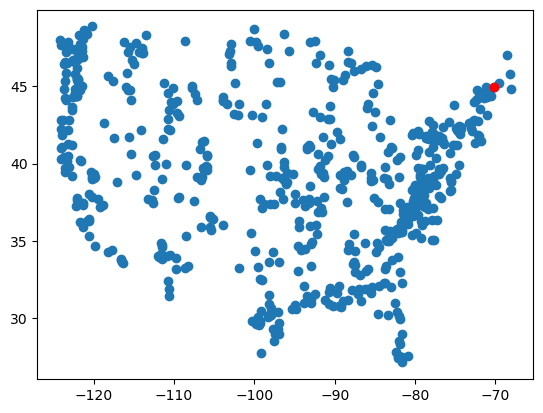

In [29]:
# random print out. delete later
i = 4
print(df_defa_metric['kge'].values[i])
print(met_stats_sse[i,:, 0])
print(met_stats_lse[i,:, 0])
print(dssurf.zbedrock.values[i])

plt.scatter(df_info['lon_cen'], df_info['lat_cen'])
plt.scatter(df_info['lon_cen'].values[i], df_info['lat_cen'].values[i], color='r')

In [30]:
df_info.iloc[i]

hru_id                                                     1047000
ann_P                                                          0.0
lon_cen                                                  -70.16213
lat_cen                                                   44.98744
AREA                                                 904956194.351
elev_mean                                               379.779978
ave_T                                                          NaN
july_T                                                         NaN
Perimeter                                                   310157
Source                                                   RawCAMELS
latoutlet                                                  44.8692
lonoutlet                                                 -69.9551
areaUSGS                                                     909.1
RawCAMELSarea                                           904.956194
RawTDXarea                                              914.49

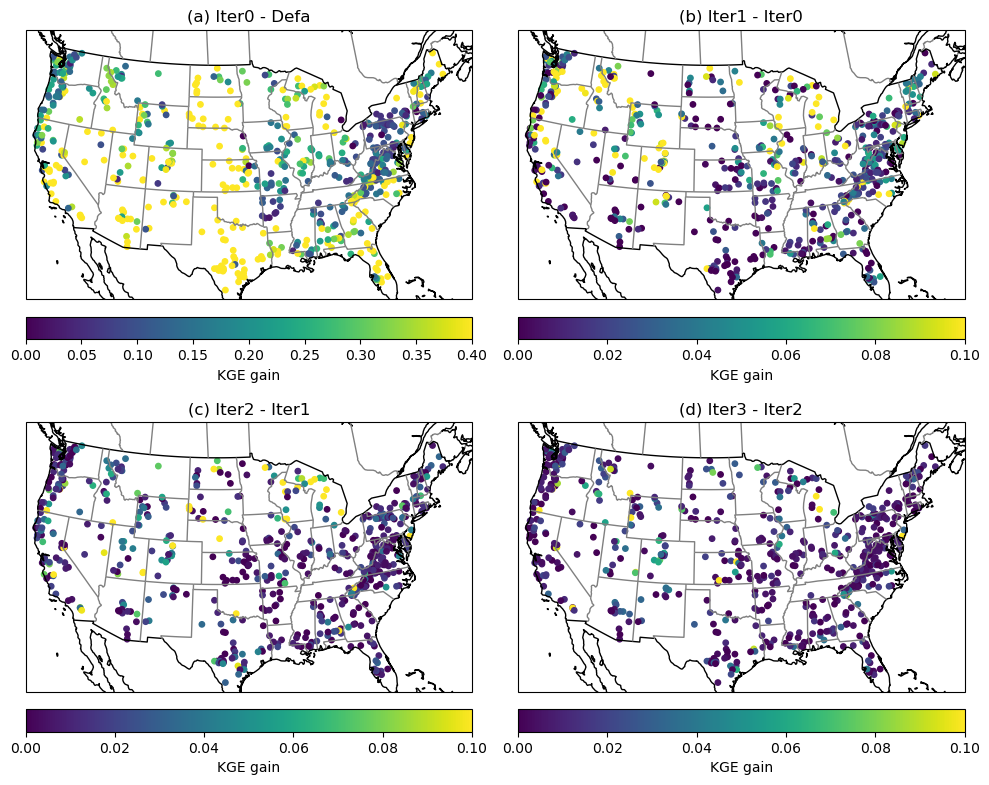

In [100]:
# LSE improvement against 

dplot = []
for i in range(iternum):
    if i==0:
        dplot.append(met_stats_lse[:,i,0] - df_defa_metric[metname].values)
    else:
        dplot.append(met_stats_lse[:,i,0] - met_stats_lse[:,i-1,0])

vmins = [0, 0, 0, 0]
vmaxs = [0.4, 0.1, 0.1, 0.1]
title = ['(a) Iter0 - Defa', '(b) Iter1 - Iter0', '(c) Iter2 - Iter1', '(d) Iter3 - Iter2']

lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

fig = plt.figure(figsize=[10, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = vmins[i], vmax=vmaxs[i], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
plt.savefig('LSE_4iter_KGEgain_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

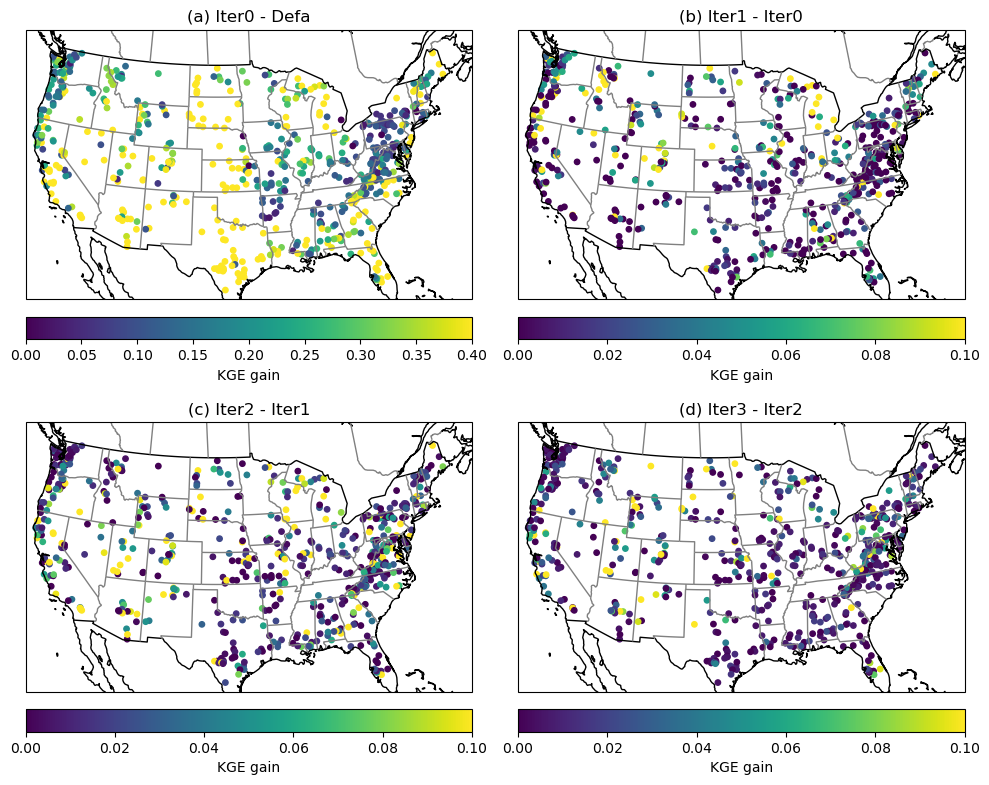

In [101]:
# SSE improvement against 

dplot = []
for i in range(iternum):
    if i==0:
        dplot.append(met_stats_sse[:,i,0] - df_defa_metric[metname].values)
    else:
        dplot.append(met_stats_sse[:,i,0] - met_stats_sse[:,i-1,0])

vmins = [0, 0, 0, 0]
vmaxs = [0.4, 0.1, 0.1, 0.1]
title = ['(a) Iter0 - Defa', '(b) Iter1 - Iter0', '(c) Iter2 - Iter1', '(d) Iter3 - Iter2']

lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

fig = plt.figure(figsize=[10, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = vmins[i], vmax=vmaxs[i], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
plt.savefig('SSE_4iter_KGEgain_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
# ratio of basins improve against the previous iter
ratio = np.nan * np.zeros([iternum, 2]) # sse/lse
mag = np.nan * np.zeros([iternum, 2, 2]) # sse/lse; mean/median
din = [met_stats_sse, met_stats_lse]
for i in range(iternum):
    for j in range(2):
        if i == 0:
            mag[i,j,0] = np.nanmean(din[j][:,i,0] - df_defa_metric[metname].values)
            mag[i,j,1] = np.nanmedian(din[j][:,i,0] - df_defa_metric[metname].values)
            ratio[i,j] = np.sum(din[j][:,i,0]>df_defa_metric[metname].values) / len(df_info)
        else:
            mag[i,j,0] = np.nanmean(din[j][:,i,0] - din[j][:,i-1,0])
            mag[i,j,1] = np.nanmedian(din[j][:,i,0] - din[j][:,i-1,0])
            ratio[i,j] = np.sum(din[j][:,i,0]>din[j][:,i-1,0]) / len(df_info)

print(ratio)
print('mean', mag[:,:,0])
print('median', mag[:,:,0])

[[0.99362041 0.99362041]
 [0.57894737 0.80861244]
 [0.81020734 0.83732057]
 [0.79106858 0.84529506]]
mean [[ 1.59649540e+00  1.59649540e+00]
 [-8.81230566e-04  4.65529827e-02]
 [ 3.98501775e-02  2.29271490e-02]
 [ 2.20909522e-02  1.60301560e-02]]
median [[ 1.59649540e+00  1.59649540e+00]
 [-8.81230566e-04  4.65529827e-02]
 [ 3.98501775e-02  2.29271490e-02]
 [ 2.20909522e-02  1.60301560e-02]]


In [10]:
# improvement magnitude
for i in range(3):
    print(np.nanmean(met_stats_lse[:,:,i],axis=0))
    print(np.nanmean(met_stats_sse[:,:,i],axis=0))

[0.38360896 0.43016195 0.4530891  0.46911925]
[0.38360896 0.38272773 0.4241375  0.44622845]
[-0.78649342  0.32712021  0.36150423  0.29764143]
[-0.78649342  0.28868224  0.35179585  0.38062103]
[-0.49698201  0.33923257  0.38024579  0.39795285]
[-0.49698201  0.30167409  0.36333949  0.40017927]


# Comapre LSE and SSE

In [12]:
# met_stats_lse  # best; mean; median

# # for each iter, how many basins where best(lse) is better than best(sse)
# ratio1 = np.zeros(iternum-1)
# for i in range(1, 4): # no need to consider iter-0 
#     ratio1[i-1] = np.sum(met_stats_lse[:,i, 0] > met_stats_sse[:,i, 0] ) / np.sum(~np.isnan(met_stats_lse[:,i, 0]))


# for each iter, how many basins where iter-x is better than iter-0
ratio1 = np.zeros([iternum-1,2])
for i in range(1, 4): # no need to consider iter-0 
    ratio1[i-1, 0] = np.sum(met_stats_lse[:,i, 0] > met_stats_lse[:,0, 0] ) / np.sum(~np.isnan(met_stats_lse[:,i, 0]))
    ratio1[i-1, 1] = np.sum(met_stats_sse[:,i, 0] > met_stats_sse[:,0, 0] ) / np.sum(~np.isnan(met_stats_sse[:,i, 0]))


# for each iter, how many basins where lse/sse improve against its previous iteration
# note that for sse, iter-1 is a low benchmark, partly contributing to high iter-2 (and maybe iter-3?)
ratio2 = np.zeros([iternum-1, 2])
for i in range(1, 4): # no need to consider iter-0 
    ratio2[i-1, 0] = np.sum(met_stats_lse[:,i, 0] > met_stats_lse[:,i-1, 0] ) / np.sum(~np.isnan(met_stats_lse[:,i, 0]))
    ratio2[i-1, 1] = np.sum(met_stats_sse[:,i, 0] > met_stats_sse[:,i-1, 0] ) / np.sum(~np.isnan(met_stats_sse[:,i, 0]))

# what is the improvement of iter-1 .. against iter-0 (LHS)
kge_impr_vs0 = np.zeros([len(df_info), 2, iternum-1])
for i in range(1, 4): # no need to consider iter-0 
    kge_impr_vs0[:,0,i-1] =  met_stats_lse[:,i,0] - met_stats_lse[:,0,0]
    kge_impr_vs0[:,1,i-1] =  met_stats_sse[:,i,0] - met_stats_sse[:,0,0]

# what is the optimal kge after all iterations
kge_best = np.zeros([len(df_info), iternum-1, 2])
for i in range(1, 4):
    dtmplse = np.hstack([met_stats_lse[:,:i+1,0], df_defa_metric[metname].values[:, np.newaxis]])
    kge_best[:,i-1,0] = np.nanmax(dtmplse, axis=1)
    dtmpsse = np.hstack([met_stats_sse[:,:i+1,0], df_defa_metric[metname].values[:, np.newaxis]])
    kge_best[:,i-1,1] = np.nanmax(dtmpsse, axis=1)


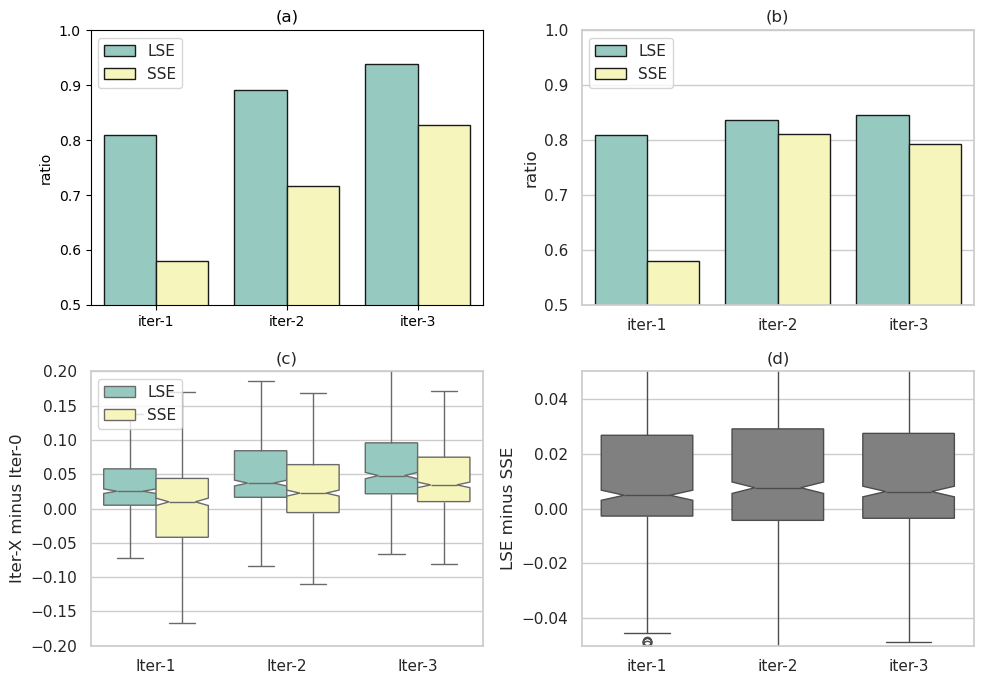

In [16]:
fig = plt.figure(figsize=[10, 7])

lon = df_info['lon_cen'].values
lat = df_info['lat_cen'].values


fig.add_subplot(2, 2, 1)

df_ratio1 = pd.DataFrame()
df_ratio1['ratio'] = np.hstack([ratio1[:,0], ratio1[:,1]])
df_ratio1['iter'] = ['iter-1','iter-2','iter-3','iter-1','iter-2','iter-3']
df_ratio1['method'] = ['LSE', 'LSE', 'LSE', 'SSE', 'SSE', 'SSE']

sns.set(style="whitegrid")
sns.barplot(data=df_ratio1, x="iter", y="ratio", hue="method", edgecolor='k', palette='Set3')
plt.legend(loc='upper left')
plt.ylim(0.5, 1)
plt.xlabel('')
plt.title('(a)')

fig.add_subplot(2, 2, 2)

df_ratio2 = pd.DataFrame()
df_ratio2['ratio'] = np.hstack([ratio2[:,0], ratio2[:,1]])
df_ratio2['iter'] = ['iter-1','iter-2','iter-3','iter-1','iter-2','iter-3']
df_ratio2['method'] = ['LSE', 'LSE', 'LSE', 'SSE', 'SSE', 'SSE']

sns.set(style="whitegrid")
sns.barplot(data=df_ratio2, x="iter", y="ratio", hue="method", edgecolor='k', palette='Set3')
plt.legend(loc='upper left')
plt.ylim(0.5, 1)
plt.xlabel('')
plt.title('(b)')

fig.add_subplot(2, 2, 3)

data = kge_impr_vs0.reshape(-1, 3)
df = pd.DataFrame(data, columns=['Iter-1', 'Iter-2', 'Iter-3'])
basin = np.repeat(np.arange(1, 628), 2)
type_ = np.tile(['LSE', 'SSE'], 627)
df['Basin'] = basin
df['method'] = type_
df_kge_impr = df.melt(id_vars=['Basin', 'method'], var_name='iter', value_name="KGEdiff")

sns.set(style="whitegrid")
sns.boxplot(data=df_kge_impr, x="iter", y="KGEdiff", hue="method", fliersize=0, palette='Set3', notch=True)
plt.ylim(-0.2, 0.2)
plt.legend(loc='upper left')
plt.ylabel("Iter-X minus Iter-0")
plt.xlabel('')
plt.title('(c)')

fig.add_subplot(2, 2, 4)
d = np.hstack([kge_best[:,i,0]-kge_best[:,i,1] for i in range(3)])
df_kgediff = pd.DataFrame()
df_kgediff['KGEdiff'] = d

iter = []
for i in range(3):
    iter = iter + [f'iter-{i+1}'] * kge_best.shape[0]
df_kgediff['iter'] = iter

sns.set(style="whitegrid")
sns.boxplot(data=df_kgediff, x="iter", y="KGEdiff", color='grey', width=0.7, notch=True)
plt.ylim(-0.05, 0.05)
plt.ylabel("LSE minus SSE")
plt.xlabel('')
plt.title('(d)')

plt.tight_layout()
# plt.savefig('LSEvsSSE_statistics.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


In [17]:
df_ratio1

,ratio,iter,method
0,0.808612,iter-1,LSE
1,0.891547,iter-2,LSE
2,0.939394,iter-3,LSE
3,0.578947,iter-1,SSE
4,0.717252,iter-2,SSE
5,0.827476,iter-3,SSE


In [25]:
# improvement against iter-0
for i in [1,2,3]:
    for j in ['LSE', 'SSE']:
        dij = df_kge_impr[ (df_kge_impr['method']==j) & (df_kge_impr['iter'] == f'Iter-{i}') ]
        print(i, j, np.nanmedian(dij['KGEdiff'].values), np.nanmean(dij['KGEdiff'].values))

1 LSE 0.025301113611270187 0.046552982654861054
1 SSE 0.00980089602167089 -0.0008812305655746609
2 LSE 0.03715087019316171 0.06948013161278307
2 SSE 0.022536203689427076 0.03881943386641117
3 LSE 0.04807875187320171 0.08551028759060912
3 SSE 0.03450157800192788 0.06091038602659483


In [29]:
for i in [1,2,3]:
    dij = df_kgediff[ (df_kgediff['iter'] == f'iter-{i}') ]
    print(i, np.nanmedian(dij['KGEdiff'].values), np.nanmean(dij['KGEdiff'].values))


1 0.004856818931433082 0.015169644347693396
2 0.007600553065564897 0.015777686803155142
3 0.006204262058958854 0.016143674954448156


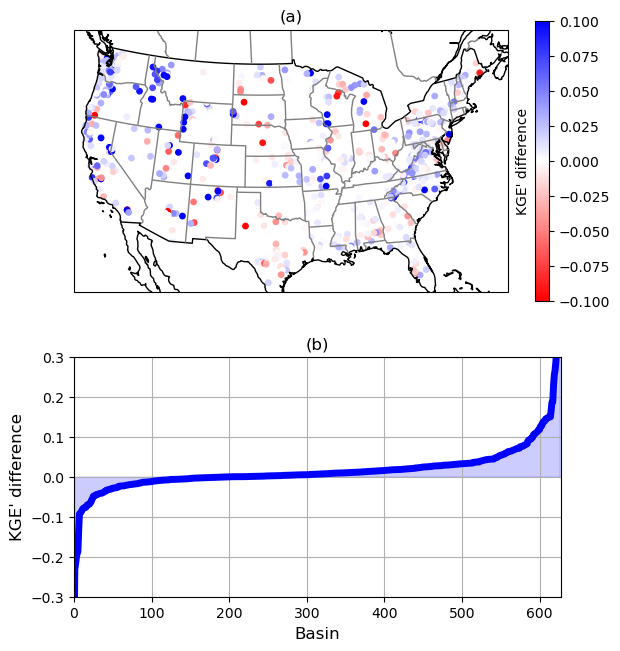

In [11]:
# map of the last improvement

diff = kge_best[:,2,0]-kge_best[:,2,1]

lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

fig = plt.figure(figsize=[7, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(2, 1, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(lon, lat, 15, diff,  vmin = -0.1, vmax=0.1, transform=transf, cmap='bwr_r')
ax.set_title("(a)")
cax = plt.colorbar(p, ax=ax, location='right', shrink=1, label="KGE' difference", pad=0.05)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')



ax4 = fig.add_subplot(2, 1, 2)
ax4.plot(np.sort(diff), 'b-', linewidth=5, label="KGE'")
ax4.fill_between(range(len(diff)), np.sort(diff), alpha=0.2, color='blue')
ax4.set_xlabel('Basin', fontsize=12)
ax4.set_ylabel("KGE' difference", fontsize=12)
ax4.set_ylim(-0.3, 0.3)
ax4.set_xlim(0, 627)
ax4.grid(True)
ax4.set_title("(b)")


pos = list(ax4.get_position().bounds)
pos[3] = pos[3] - 0.05
pos[2] = pos[2] - 0.08
pos[1] = pos[1] + 0.05
pos[0] = pos[0] + 0.0

ax4.set_position(pos)


# plt.tight_layout()
plt.savefig('LSEvsSSE_statistics_iter3_KGEdiff.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Present the improvement of LSE iterations

## different iterations

In [13]:
metname = 'kge'
approach = 'max'
# approach = 'median'

labels = ['defa']
for i in range(iternum):
    labels.append(f'iter-{i}')

optmz_all = []
df_all = [df_lse_metric, df_sse_metric]

for m in range(2):
    dfm = df_all[m]

    metric_all = []
    metric_all.append(df_defa_metric[metname].values)
    for i in range(iternum):
        indi = dfm['iter']==i
        metric_all.append(dfm[metname][indi].values)
    
    metric_optmz = np.nan * np.zeros([len(df_info), iternum+1])
    metric_optmz[:,0] = df_defa_metric[metname].values
    for i in range(iternum):
        indi = (dfm['iter']==i)
        for j in range(len(df_info)):
            indij = indi & (dfm['basin']==j)
            dij = dfm[indij][metname].values
            if approach == 'max':
                metric_optmz[j, i+1] = np.nanmax(dij)
            elif approach == 'min':
                metric_optmz[j, i+1] = np.nanmin(dij)
            elif approach == 'median':
                metric_optmz[j, i+1] = np.nanmedian(dij)

    optmz_all.append(metric_optmz)
    
    print(labels)
    print(np.nanmean(metric_optmz, axis=0))
    print(np.nanmedian(metric_optmz, axis=0))

['defa', 'iter-0', 'iter-1', 'iter-2', 'iter-3']
[-1.21288643  0.38360896  0.43016195  0.4530891   0.46911925]
[0.19520327 0.46116677 0.50478524 0.51495102 0.52538579]


/glade/derecho/scratch/guoqiang/tmp/ipykernel_60203/204475850.py:29: RuntimeWarning: All-NaN slice encountered
  metric_optmz[j, i+1] = np.nanmax(dij)


['defa', 'iter-0', 'iter-1', 'iter-2', 'iter-3']
[-1.21288643  0.38360896  0.38272773  0.4241375   0.44622845]
[0.19520327 0.46116677 0.46508245 0.49349101 0.5140363 ]


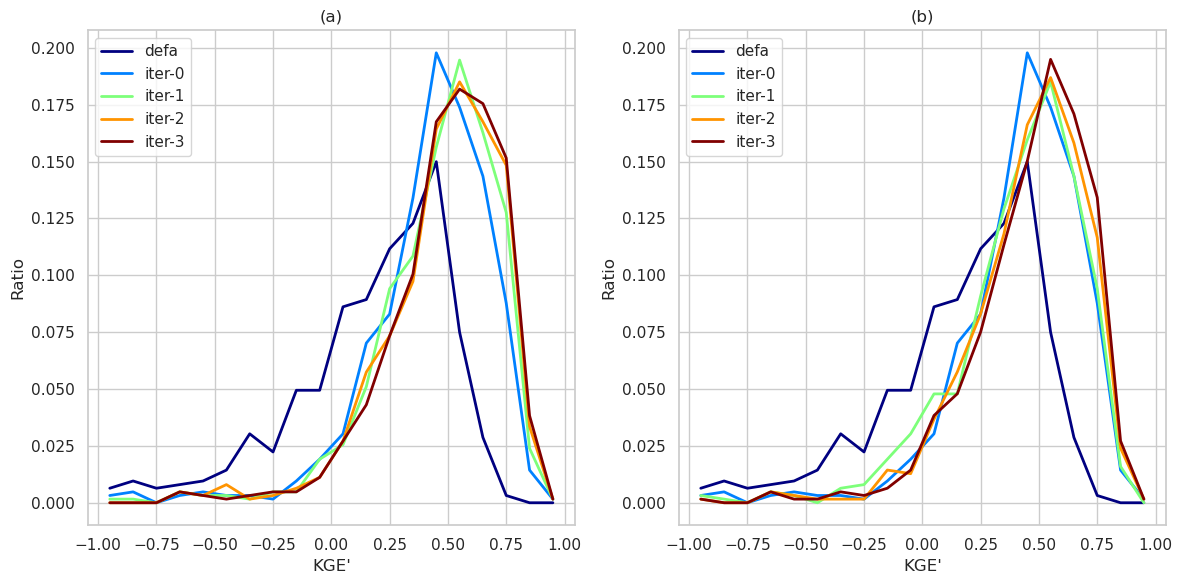

In [191]:
bins0 = np.arange(-1, 1.1, 0.1)
colors = cm.jet(np.linspace(0, 1, metric_optmz.shape[1]))

fig = plt.figure(figsize=[12, 6])

title = ['(a)', '(b)']
for m in range(2):
    fig.add_subplot(1,2,m+1)

    for i in range(optmz_all[m].shape[1]):
        bins, dm = cal_ratio_within_bins(optmz_all[m][:,i], bins0)
        plt.plot(bins, dm, color=colors[i], label=labels[i], linewidth=2)
    
    plt.xlabel("KGE'")
    plt.ylabel("Ratio")
    plt.title(title[m])

    plt.legend()

plt.tight_layout()
plt.savefig('LSEvsSSE_alliter_KGE_CDF.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Example basins of LSE optmz

In [17]:
# -24 shows that iter-3 has much larger spread than iter-1 and iter-2 and reaches better performance
# -26 shows that all iter-0 is worse than defa, but following iterations optimize parameter
# -27 shows a good increase rate, but iter-3 has some negative KGEs, indicating the unrobustness of emulator and the need of multiple optmz outputs
# -5; -30 shows a very good example
# it deserves to plot all basins to check their interesting patterns

# select a basin
# lastdiff = metric_optmz[:,-1] - metric_optmz[:,-2]
lastdiff = optmz_all[0][:,-1] - optmz_all[0][:,-2]

useind = [-5, -30, -27, -26]
indtar_all = [np.argsort(lastdiff)[i] for i in useind]
print(indtar_all)
print(metric_optmz[indtar_all, :])

[310, 428, 485, 257]
[[-0.05145964  0.11091464 -0.00746143  0.02905378  0.04244695]
 [-0.08977788  0.50784986  0.58490743  0.61692012  0.62415044]
 [-2.74483237  0.38883795 -0.30788876 -0.07046603  0.09284816]
 [ 0.30660313  0.30660313  0.50362605  0.58705698  0.63472904]]


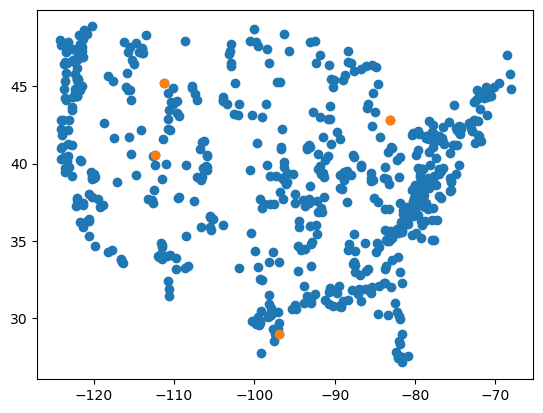

In [20]:
lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values
plt.scatter(lon, lat)
plt.scatter(lon[indtar_all], lat[indtar_all])

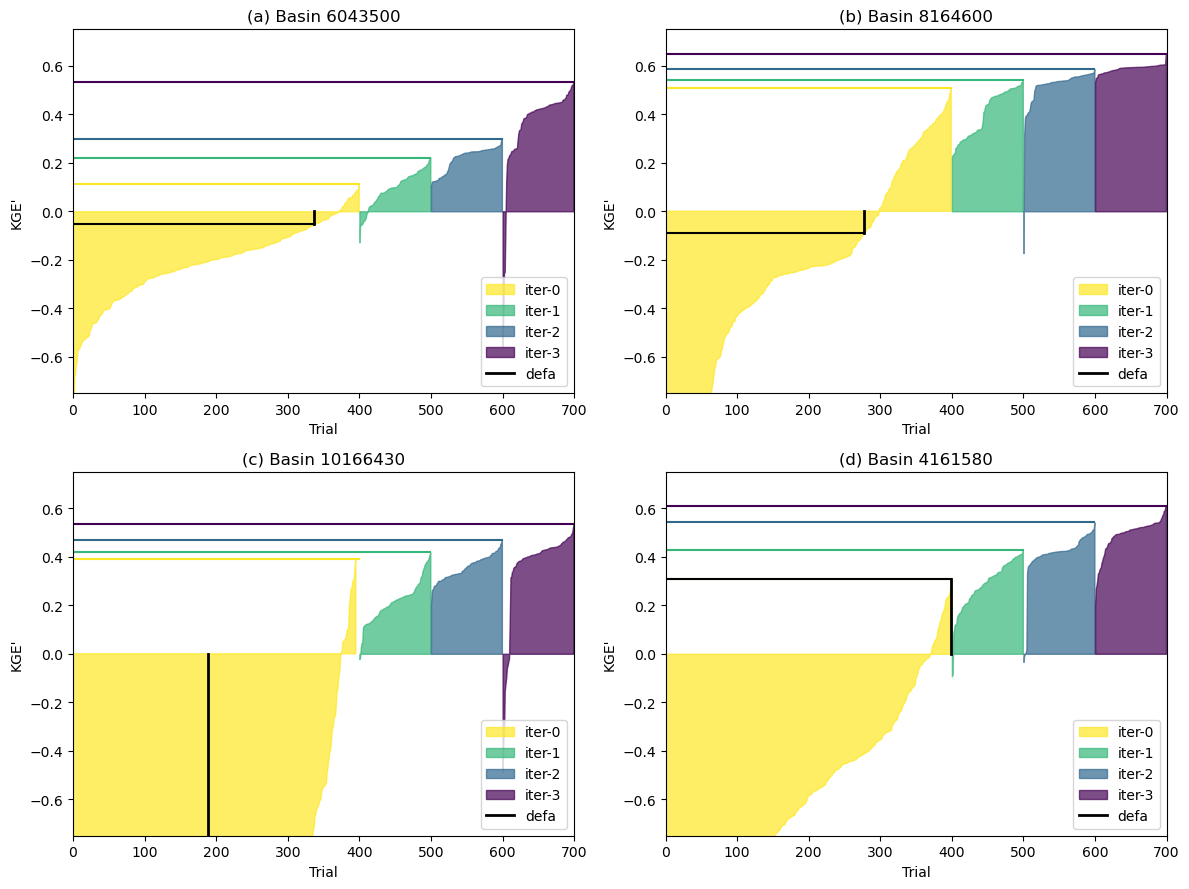

In [21]:
# plot selected basins

idall = [df_info.iloc[i]['hru_id'] for i in indtar_all]
titles = 'abcd'
titles = [f'({titles[i]}) Basin {idall[i]}' for i in range(len(idall))]


# Create a colormap
cmap = plt.get_cmap('viridis_r', iternum)
    
# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=[12, 9])
axs = axs.flatten()
    

for b in range(len(indtar_all)):

    ax = axs[b]

    indtar = indtar_all[b]

    df_tar = df_lse_metric[df_lse_metric['basin']==indtar]
    df_tar.index = np.arange(len(df_tar))
    
    for i in range(iternum):
        dfi = df_tar[df_tar['iter'] == i]
        x, y = dfi.index, dfi['kge'].values
        indi = np.argsort(y)
        
        # Sort x and y based on the sorted indices
        x_sorted, y_sorted = x, y[indi]
        
        # Use fill_between to create a filled plot
        ax.fill_between(x_sorted, y_sorted, color=cmap(i / iternum), label=f'iter-{i}', alpha=0.7)
    
        ax.plot([0, x_sorted[-1]], [np.nanmax(y_sorted), np.nanmax(y_sorted)], color=cmap(i / iternum))
        
    # Plot the default line last to ensure it's on top, but collect its handle first
    dfi = df_tar[df_tar['iter'] == 0]
    xdefa = np.sum(dfi['kge'].values[0] > dfi['kge'].values)
    default_handle, = ax.plot([xdefa, xdefa], [0, dfi['kge'].values[0]], color='k', linewidth=2, label='defa')
    ax.plot([0, xdefa], [dfi['kge'].values[0], dfi['kge'].values[0]], color='k')
    
    # set axis
    ax.set_ylim(-0.75, 0.75)
    ax.set_xlim(0, len(df_tar))
    ax.set_ylabel("KGE'")
    ax.set_xlabel('Trial')

    ax.set_title(titles[b])
    
    # # Collect all legend handles and labels
    # handles, labels = ax.get_legend_handles_labels()
    
    # # Reorder the handles and labels to ensure 'defa' is first
    # handles = [default_handle] + handles[:-1]
    # labels = ['defa'] + labels[:-1]
    
    # # Create the legend
    # ax.legend(handles, labels, loc='lower right')
    ax.legend(loc='lower right')

plt.tight_layout()
# plt.savefig('LSE_4iter_optmz_4basins.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## Example basins of LSE optmz (each cluster has one example basin)

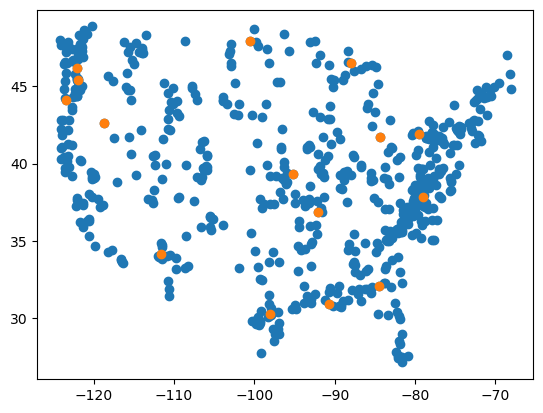

In [69]:
df_cluster = pd.read_csv('../../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt')
clusters = []
for id in df_info['hru_id'].values:
    clusters.append(df_cluster['flood_cluster'].values[df_cluster['Camels_IDs'].values==id][0])
clusters = np.array(clusters)


np.random.seed(1234)

indtar_all = []
for c in np.arange(1, 16):
    indc = np.where(clusters==c)[0]
    indtar_all.append(indc[np.random.randint(0, len(indc))])
# indtar_all
lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values
plt.scatter(lon, lat)
plt.scatter(lon[indtar_all], lat[indtar_all])

In [70]:
# indtar_all = [546, 597, 624, 507, 479, 324, 329, 434, 257, 288, 192, 390, 31, 95, 144]

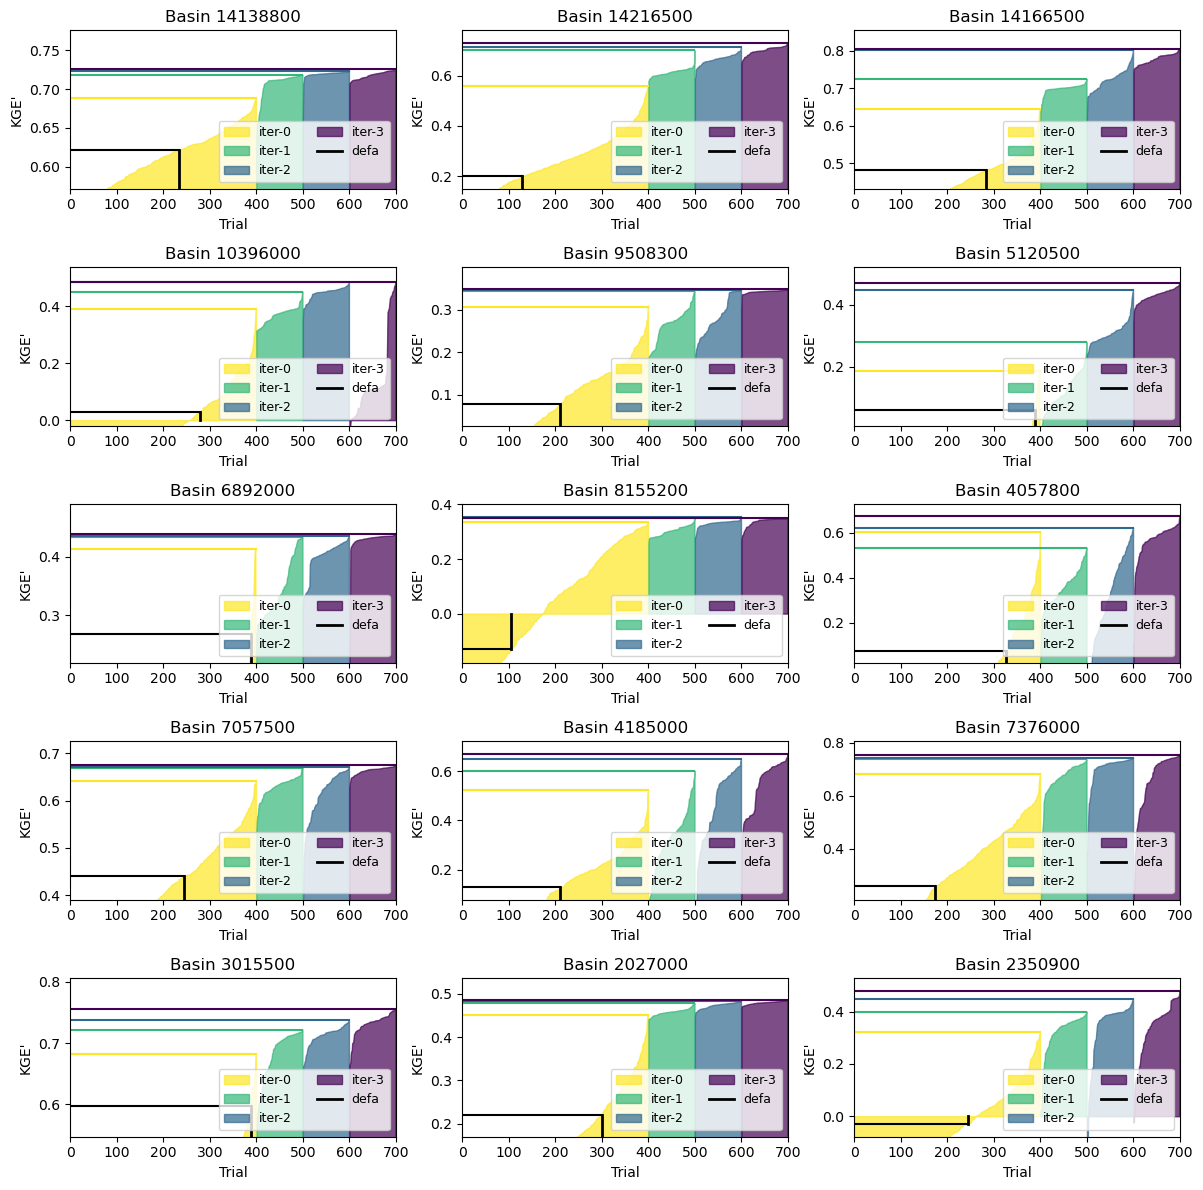

In [72]:
# plot selected basins

idall = [df_info.iloc[i]['hru_id'] for i in indtar_all]
titles = [f'Basin {idall[i]}' for i in range(len(idall))]


# Create a colormap
cmap = plt.get_cmap('viridis_r', iternum)
    
# Create a figure and axis
fig, axs = plt.subplots(5, 3, figsize=[12, 12])
axs = axs.flatten()
    

for b in range(len(indtar_all)):

    ax = axs[b]

    indtar = indtar_all[b]

    df_tar = df_lse_metric[df_lse_metric['basin']==indtar]
    df_tar.index = np.arange(len(df_tar))
    
    for i in range(iternum):
        dfi = df_tar[df_tar['iter'] == i]
        x, y = dfi.index, dfi['kge'].values
        indi = np.argsort(y)
        
        # Sort x and y based on the sorted indices
        x_sorted, y_sorted = x, y[indi]
        
        # Use fill_between to create a filled plot
        ax.fill_between(x_sorted, y_sorted, color=cmap(i / iternum), label=f'iter-{i}', alpha=0.7)
    
        ax.plot([0, x_sorted[-1]], [np.nanmax(y_sorted), np.nanmax(y_sorted)], color=cmap(i / iternum))
        
    # Plot the default line last to ensure it's on top, but collect its handle first
    dfi = df_tar[df_tar['iter'] == 0]
    xdefa = np.sum(dfi['kge'].values[0] > dfi['kge'].values)
    default_handle, = ax.plot([xdefa, xdefa], [0, dfi['kge'].values[0]], color='k', linewidth=2, label='defa')
    ax.plot([0, xdefa], [dfi['kge'].values[0], dfi['kge'].values[0]], color='k')
    
    # set axis
    ax.set_ylim(dfi['kge'].values[0]-0.05, np.nanmax(y_sorted)+0.05)
    ax.set_xlim(0, len(df_tar))
    ax.set_ylabel("KGE'")
    ax.set_xlabel('Trial')

    ax.set_title(titles[b])

    # # Create the legend
    # ax.legend(handles, labels, loc='lower right')
    ax.legend(loc='lower right', ncols=2, fontsize=9)

plt.tight_layout()
plt.savefig('LSE_4iter_optmz_15basins.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## all basin median

In [22]:
datam = [np.zeros([627, 400]), np.zeros([627, 100]), np.zeros([627, 100]), np.zeros([627, 100])]
datadefa = np.zeros(627)

for b in range(len(df_info)):

    df_tar = df_lse_metric[df_lse_metric['basin']==b]
    df_tar.index = np.arange(len(df_tar))
    
    for i in range(iternum):
        dfi = df_tar[df_tar['iter'] == i]
        x, y = dfi.index, dfi['kge'].values
        datam[i][b,:] = np.sort(y)

    datadefa[b] = df_tar[df_tar['iter'] == 0]['kge'].values[0]

data_allm_lse = [np.nanmedian(i, axis=0) for i in datam]
data_defam_lse = np.nanmedian(datadefa)

In [23]:
datam = [np.zeros([627, 400]), np.zeros([627, 100]), np.zeros([627, 100]), np.zeros([627, 100])]
datadefa = np.zeros(627)

for b in range(len(df_info)):

    df_tar = df_sse_metric[df_sse_metric['basin']==b]
    df_tar.index = np.arange(len(df_tar))
    
    for i in range(iternum):
        dfi = df_tar[df_tar['iter'] == i]
        x, y = dfi.index, dfi['kge'].values
        datam[i][b,:] = np.sort(y)

    datadefa[b] = df_tar[df_tar['iter'] == 0]['kge'].values[0]

data_allm_sse = [np.nanmedian(i, axis=0) for i in datam]
data_defam_sse = np.nanmedian(datadefa)

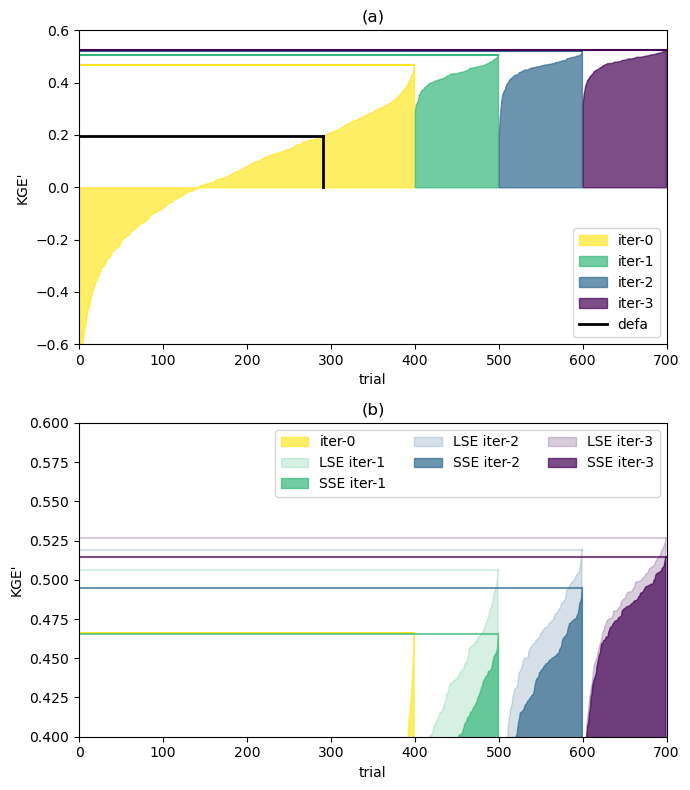

In [39]:
fig = plt.figure(figsize=[7, 8])


fig.add_subplot(2,1,1)
flag = 0
cmap = plt.get_cmap('viridis_r', iternum)
for i in range(iternum):
    x = np.arange(flag, flag+len(data_allm_lse[i]))
    flag = flag+len(data_allm_lse[i])
    y = data_allm_lse[i]
    plt.fill_between(x, y, color=cmap(i / iternum), label=f'iter-{i}', alpha=0.7)
    plt.plot([0, x[-1]], [np.nanmax(y), np.nanmax(y)], color=cmap(i / iternum))


xdefa = np.sum(data_allm_lse[0] < data_defam_lse)
plt.plot([xdefa, xdefa], [data_defam_lse, 0], color='k', linewidth=2, label='defa')
plt.plot([0, xdefa], [data_defam_lse, data_defam_lse], color='k', linewidth=2)
plt.ylim(-0.6, 0.6)
plt.xlim(0, 700)
plt.ylabel("KGE'")
plt.xlabel('trial')
plt.legend()
plt.title('(a)')

fig.add_subplot(2,1,2)
flag = 0
cmap1 = plt.get_cmap('viridis_r', iternum)
# cmap2 = plt.get_cmap('jet', iternum)
cmap2 = cmap1
for i in range(iternum):
    x = np.arange(flag, flag+len(data_allm_lse[i]))
    
    if i>0:
        y = data_allm_lse[i]
        plt.fill_between(x, y, color=cmap1(i / iternum), label=f'LSE iter-{i}', alpha=0.2)
        plt.plot([0, x[-1]], [np.nanmax(y), np.nanmax(y)], color=cmap1(i / iternum), alpha=0.2)
        
        y = data_allm_sse[i]
        plt.fill_between(x, y, color=cmap2(i / iternum), label=f'SSE iter-{i}', alpha=0.7)
        plt.plot([0, x[-1]], [np.nanmax(y), np.nanmax(y)], color=cmap2(i / iternum), alpha=0.7)

    else:
        y = data_allm_lse[i]
        plt.fill_between(x, y, color=cmap1(i / iternum), label=f'iter-{i}', alpha=0.7)
        plt.plot([0, x[-1]], [np.nanmax(y), np.nanmax(y)], color=cmap1(i / iternum))
        pass
        
    flag = flag+len(data_allm_sse[i])

plt.ylim(0.4, 0.6)
plt.xlim(0, 700)
plt.ylabel("KGE'")
plt.xlabel('trial')
plt.legend(ncol=3)
plt.title('(b)')

plt.tight_layout()
plt.savefig('LSEandSSE_4iter_optmz_allbasins.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

## all basin all
Not very good

In [34]:

data_allm = [np.sort(i.flatten()) for i in datam]

(-1.0, 1.0)

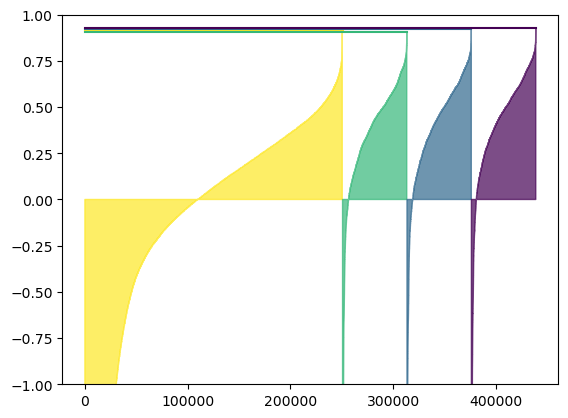

In [37]:
flag = 0
cmap = plt.get_cmap('viridis_r', iternum)
for i in range(iternum):
    x = np.arange(flag, flag+len(data_allm[i]))
    flag = flag+len(data_allm[i])
    y = data_allm[i]
    plt.fill_between(x, y, color=cmap(i / iternum), label=f'iter-{i}', alpha=0.7)
    plt.plot([0, x[-1]], [np.nanmax(y), np.nanmax(y)], color=cmap(i / iternum))

plt.ylim(-1,1)
